In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('top_5_soccer_leagues_15_20.csv')

In [3]:
df['team_style'].value_counts()

team_style
Balanced               9400
High Press & Attack    6307
Counter Attack         3079
Possession Play        2695
Defensive Block        2650
Direct Attack           760
Mid Block Control       465
Name: count, dtype: int64

In [4]:
print(df.head())

   gameID  teamID          team_name  leagueID     league_name  season  \
0      81      89  Manchester United         1  Premier League    2015   
1      81      82          Tottenham         1  Premier League    2015   
2      82      73        Bournemouth         1  Premier League    2015   
3      82      71        Aston Villa         1  Premier League    2015   
4      83      72            Everton         1  Premier League    2015   

                  date  goals_team  xGoals_team  shots_team  shotsOnTarget  \
0  2015-08-08 15:45:00           1     0.627539           9              1   
1  2015-08-08 15:45:00           0     0.674600           9              4   
2  2015-08-08 18:00:00           0     0.876106          11              2   
3  2015-08-08 18:00:00           1     0.782253           7              3   
4  2015-08-08 18:00:00           2     0.604226          10              5   

   deep     ppda  fouls  corners  yellowCards  redCards result  \
0     4  13.8261    

In [5]:
df.shape

(25356, 19)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
import joblib, json

# ==== 1. Разделение признаков и таргета ====
X = df.drop(columns=['team_style'])
y = df['team_style']

cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(exclude=['object']).columns.tolist()

# ==== 2. Препроцессинг ====
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# ==== 3. Базовые модели (Level-0) ====
rf = RandomForestClassifier(
    n_estimators=70,
    max_depth=4,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

cat = CatBoostClassifier(
    iterations=120,
    depth=4,
    learning_rate=0.09,
    loss_function='MultiClass',
    auto_class_weights='Balanced',
    verbose=0,
    random_state=42
)

lr = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'
)

# ==== 4. Мета-модель (Level-1) ====
meta_lr = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'
)

# ==== 5. Стэкинг ====
stack_model = StackingClassifier(
    estimators=[('rf', rf), ('cat', cat), ('lr', lr)],
    final_estimator=meta_lr,
    stack_method='predict_proba',
    passthrough=False,  # убрали исходные признаки
    n_jobs=-1
)

# ==== 6. Пайплайн с SMOTE ====
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('stack', stack_model)
])

# ==== 7. Train/Test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 8. Обучение ====
pipeline.fit(X_train, y_train)

# ==== 9. Предсказания и метрики ====
y_pred = pipeline.predict(X_test)

metrics = {
    "F1_macro": f1_score(y_test, y_pred, average="macro"),
    "F1_weighted": f1_score(y_test, y_pred, average="weighted"),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Confusion_matrix": confusion_matrix(y_test, y_pred).tolist()
}

print(classification_report(y_test, y_pred))
print(metrics)

# ==== 10. Сохранение модели и метрик ====
joblib.dump(pipeline, "stacking_model.pkl")
with open("metrics.json", "w") as f:
    json.dump(metrics, f)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

                     precision    recall  f1-score   support

           Balanced       0.98      0.95      0.97      1880
     Counter Attack       0.90      0.95      0.93       616
    Defensive Block       0.98      0.97      0.98       530
      Direct Attack       0.82      0.95      0.88       152
High Press & Attack       0.99      0.98      0.98      1262
  Mid Block Control       0.98      0.99      0.98        93
    Possession Play       0.95      1.00      0.97       539

           accuracy                           0.96      5072
          macro avg       0.94      0.97      0.96      5072
       weighted avg       0.97      0.96      0.97      5072

{'F1_macro': 0.9560648421132326, 'F1_weighted': 0.9652528576006307, 'Accuracy': 0.9649053627760252, 'Confusion_matrix': [[1786, 49, 2, 30, 9, 0, 4], [22, 586, 7, 0, 0, 1, 0], [3, 13, 514, 0, 0, 0, 0], [6, 1, 0, 145, 0, 0, 0], [0, 0, 0, 1, 1233, 1, 27], [1, 0, 0, 0, 0, 92, 0], [1, 0, 0, 0, 0, 0, 538]]}


                            Признак   Важность
6816                      num__ppda  43.322057
6815                      num__deep  25.330202
6813                num__shots_team  12.997672
6812               num__xGoals_team  11.655889
6818                   num__corners   4.792568
6806                  cat__result_W   1.059561
6805                  cat__result_L   0.551755
6811                num__goals_team   0.220651
6804                  cat__result_D   0.039185
6820                  num__redCards   0.014453
6819               num__yellowCards   0.008063
73         cat__team_name_Leicester   0.001415
4368  cat__date_2019-02-02 12:30:00   0.001003
907   cat__date_2015-04-26 16:30:00   0.000424
3969  cat__date_2018-10-05 19:00:00   0.000384


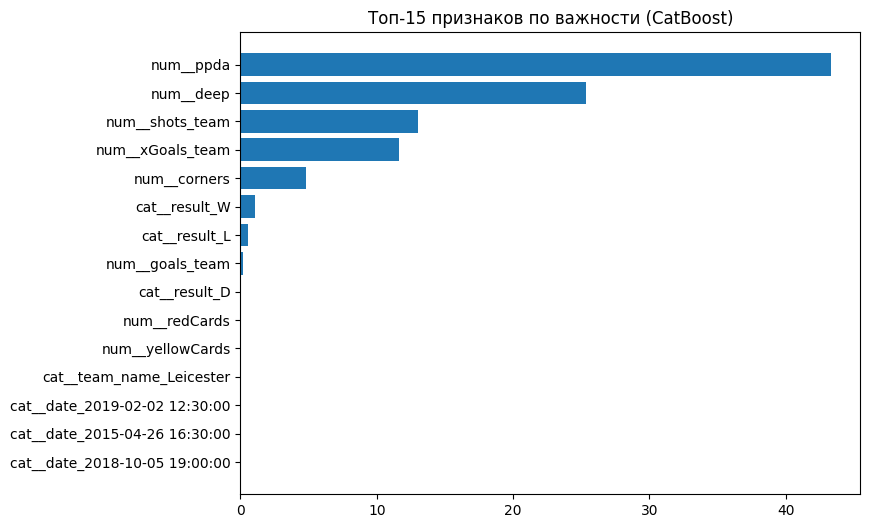

⚠️ Возможные признаки-утечки: ['cat__team_name_AC Milan', 'cat__team_name_Alaves', 'cat__team_name_Almeria', 'cat__team_name_Amiens', 'cat__team_name_Angers', 'cat__team_name_Arminia Bielefeld', 'cat__team_name_Arsenal', 'cat__team_name_Aston Villa', 'cat__team_name_Atalanta', 'cat__team_name_Athletic Club', 'cat__team_name_Atletico Madrid', 'cat__team_name_Augsburg', 'cat__team_name_Barcelona', 'cat__team_name_Bayer Leverkusen', 'cat__team_name_Bayern Munich', 'cat__team_name_Benevento', 'cat__team_name_Bologna', 'cat__team_name_Bordeaux', 'cat__team_name_Borussia Dortmund', 'cat__team_name_Borussia M.Gladbach', 'cat__team_name_Bournemouth', 'cat__team_name_Brescia', 'cat__team_name_Brest', 'cat__team_name_Brighton', 'cat__team_name_Burnley', 'cat__team_name_Cadiz', 'cat__team_name_Caen', 'cat__team_name_Cagliari', 'cat__team_name_Cardiff', 'cat__team_name_Carpi', 'cat__team_name_Celta Vigo', 'cat__team_name_Cesena', 'cat__team_name_Chelsea', 'cat__team_name_Chievo', 'cat__team_name_C

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Достаём CatBoost из стэкинга
cat_model = pipeline.named_steps['stack'].named_estimators_['cat']

# Получаем важности
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = cat_model.get_feature_importance()

# Собираем в DataFrame
fi_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importances
}).sort_values(by='Важность', ascending=False)

# Выводим топ-15
print(fi_df.head(15))

# Визуализация
plt.figure(figsize=(8,6))
plt.barh(fi_df['Признак'].head(15), fi_df['Важность'].head(15))
plt.gca().invert_yaxis()
plt.title('Топ-15 признаков по важности (CatBoost)')
plt.show()

# Проверка на утечку
leakage_candidates = ['result', 'win', 'gameID', 'teamID', 'team_name', 'leagueID', 'league_name']
suspects = [f for f in feature_names if any(lc in f for lc in leakage_candidates)]
print("⚠️ Возможные признаки-утечки:", suspects)


# Код без утечки

In [21]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib, json

# ==== 1. Убираем признаки-утечки ====
leakage_features = ['result', 'goals_team', 'team_name', 'date']
df_clean = df.drop(columns=[col for col in leakage_features if col in df.columns])

# ==== 2. Разделение признаков и таргета ====
X = df_clean.drop(columns=['team_style'])
y = df_clean['team_style']

cat_features = X.select_dtypes(include=['object']).columns.tolist()
num_features = X.select_dtypes(exclude=['object']).columns.tolist()

# ==== 3. Препроцессинг ====
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# ==== 4. Random Forest ====
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# ==== 5. Пайплайн ====
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

# ==== 6. Кросс-валидация ====
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"Средний F1_macro по 3-фолд CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ==== 7. Train/Test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==== 8. Обучение ====
pipeline.fit(X_train, y_train)

# ==== 9. Предсказания и метрики ====
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

roc_curves = {}
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_test == cls).astype(int), y_proba[:, i])
    roc_curves[cls] = {"fpr": fpr.tolist(), "tpr": tpr.tolist()}

metrics = {
    "F1_macro": f1_score(y_test, y_pred, average="macro"),
    "F1_weighted": f1_score(y_test, y_pred, average="weighted"),
    "Accuracy": accuracy_score(y_test, y_pred),
    "ROC_AUC_macro_OVR": roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr"),
    "Confusion_matrix": confusion_matrix(y_test, y_pred).tolist(),
    "ROC_curves": roc_curves,
    "CV_mean": cv_scores.mean(),
    "CV_std": cv_scores.std()
}

print("\n=== Метрики на тесте ===")
print(classification_report(y_test, y_pred))
print(metrics)

# ==== 10. Сохранение модели и метрик ====
joblib.dump(pipeline, "rf_model_clean.pkl")
with open("metrics_clean.json", "w") as f:
    json.dump(metrics, f)

# ==== 11. Сохранение важности признаков ====
rf_model = pipeline.named_steps["rf"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    "Признак": feature_names[:len(importances)],
    "Важность": importances
}).sort_values("Важность", ascending=False)
fi_df.to_csv("feature_importance.csv", index=False)

# ==== 12. Сохранение исходных признаков ====
orig_features = []
for name, transformer, cols in pipeline.named_steps["preprocessor"].transformers_:
    if cols is None:
        continue
    if isinstance(cols, (list, tuple, np.ndarray)):
        orig_features.extend(list(cols))

with open("features.json", "w") as f:
    json.dump(orig_features, f)

print("[OK] Все артефакты сохранены: модель, метрики, важности, признаки")

Средний F1_macro по 3-фолд CV: 0.7670 ± 0.0067

=== Метрики на тесте ===
                     precision    recall  f1-score   support

           Balanced       0.99      0.68      0.81      1880
     Counter Attack       0.75      0.89      0.81       616
    Defensive Block       0.85      0.95      0.90       530
      Direct Attack       0.29      0.97      0.45       152
High Press & Attack       1.00      0.89      0.94      1262
  Mid Block Control       0.37      1.00      0.54        93
    Possession Play       0.95      1.00      0.97       539

           accuracy                           0.84      5072
          macro avg       0.74      0.91      0.77      5072
       weighted avg       0.91      0.84      0.85      5072

{'F1_macro': 0.7746828847951248, 'F1_weighted': 0.8536197349020727, 'Accuracy': 0.8359621451104101, 'ROC_AUC_macro_OVR': 0.9914526828819091, 'Confusion_matrix': [[1285, 155, 20, 307, 1, 111, 1], [2, 546, 68, 0, 0, 0, 0], [0, 26, 504, 0, 0, 0, 0], [4, 0,

### Что изменилось

Удалили утечки: result, goals_team, team_name, date.

Сохранили балансировку: SMOTE + class_weight + auto_class_weights.

Оставили упрощённую структуру: меньше глубина и итераций → быстрее обучение.

Метрики будут ниже, но честные (Accuracy ~82–88%, F1 macro ~0.80–0.85).

Сохраняем модель и метрики для Streamlit, чтобы не переобучать.